In [ ]:
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
from matplotlib import pyplot as plt
import math, os, re, warnings, random
from sklearn.utils import class_weight
from kaggle_datasets import KaggleDatasets
from sklearn.model_selection import KFold,StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tensorflow.keras import optimizers, applications, Sequential, losses, metrics
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint,LearningRateScheduler

In [ ]:
def seed_everything(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = "1"


seed = 0
seed_everything(seed)
warnings.filterwarnings('ignore')


In [ ]:
strategy = tf.distribute.get_strategy()
AUTO = tf.data.experimental.AUTOTUNE
REPLICAS = strategy.num_replicas_in_sync
print('# REPLICAS: {}'.format(REPLICAS))

# REPLICAS: 1


In [ ]:
BATCH_SIZE = 32 * REPLICAS
LEARNING_RATE = 3e-5 * REPLICAS
EPOCHS = 35
HEIGHT = 300
WIDTH = 300
CHANNELS = 3
ES_PATIENCE = 10
AUG_BATCH=BATCH_SIZE
IMAGE_SIZE=[HEIGHT,WIDTH]

In [ ]:
# GCS_PATH = KaggleDatasets().get_gcs_path('leukemia-classification')
GCS_PATH = '../input/leukemia-classification/'

In [ ]:

train_dataset_0_all = glob.glob(GCS_PATH + '/C-NMC_Leukemia/training_data/fold_0/all/*.bmp')
train_dataset_0_hem = glob.glob(GCS_PATH + '/C-NMC_Leukemia/training_data/fold_0/hem/*.bmp')
train_dataset_1_all = glob.glob(GCS_PATH + '/C-NMC_Leukemia/training_data/fold_1/all/*.bmp')
train_dataset_1_hem = glob.glob(GCS_PATH + '/C-NMC_Leukemia/training_data/fold_1/hem/*.bmp')
train_dataset_2_all = glob.glob(GCS_PATH + '/C-NMC_Leukemia/training_data/fold_2/all/*.bmp')
train_dataset_2_hem = glob.glob(GCS_PATH + '/C-NMC_Leukemia/training_data/fold_2/hem/*.bmp')


In [ ]:
len(train_dataset_0_all)

2397

In [ ]:
# Include Validation data as well :-
test_data=pd.read_csv(GCS_PATH + '/C-NMC_Leukemia/validation_data/C-NMC_test_prelim_phase_data_labels.csv')

at = test_data[test_data['labels'] == 1]
ht = test_data[test_data['labels'] == 0]

test_PATH = GCS_PATH + '/C-NMC_Leukemia/validation_data/C-NMC_test_prelim_phase_data/'
ATL = [test_PATH +  i for i in list(at.new_names)]
HTL = [test_PATH +  i for i in list(ht.new_names)]


In [ ]:
# Merging happens here:-
A=[]
H=[]
A.extend(train_dataset_0_all)
A.extend(train_dataset_1_all)
A.extend(train_dataset_2_all)

H.extend(train_dataset_0_hem)
H.extend(train_dataset_1_hem)
H.extend(train_dataset_2_hem)

print(len(A))
print(len(H))

# Create labels :-
Label_A = [1]*len(A)
Label_H = [0]*len(H)

# Converting to pandas dataframe for easier access:-
A.extend(H)
Label_A.extend(Label_H)
df = pd.DataFrame({'path':A, 'label':Label_A})
df = df.sample(frac=1).reset_index(drop=True)

FILENAMES = df['path']
LABELS = df['label']

print('Final Merged Data:-')
df

7272
3389
Final Merged Data:-


,path,label
0,../input/leukemia-classification//C-NMC_Leukem...,1
1,../input/leukemia-classification//C-NMC_Leukem...,1
2,../input/leukemia-classification//C-NMC_Leukem...,0
3,../input/leukemia-classification//C-NMC_Leukem...,0
4,../input/leukemia-classification//C-NMC_Leukem...,1
...,...,...
10656,../input/leukemia-classification//C-NMC_Leukem...,0
10657,../input/leukemia-classification//C-NMC_Leukem...,1
10658,../input/leukemia-classification//C-NMC_Leukem...,1
10659,../input/leukemia-classification//C-NMC_Leukem...,0


In [ ]:
cw = class_weight.compute_class_weight('balanced',
                                        np.unique(LABELS),
                                        LABELS)
cw = {0:cw[0], 1:cw[1]}

In [ ]:
cw

{0: 1.5728828562997934, 1: 0.7330170517051705}

In [ ]:
# Define Augmentation function:-
def data_augment(image, label):

    p_spatial = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_rotate = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_pixel = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_shear = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_crop = tf.random.uniform([], 0, 1.0, dtype=tf.float32)

    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_flip_left_right(image)

    if p_spatial > .75:
        image = tf.image.transpose(image)

    if p_pixel >= .2:
        if p_pixel >= .8:
            image = tf.image.random_saturation(image, lower=.7, upper=1.3)
        elif p_pixel >= .6:
            image = tf.image.random_contrast(image, lower=.8, upper=1.2)
        elif p_pixel >= .4:
            image = tf.image.random_brightness(image, max_delta=.1)
        else:
            image = tf.image.adjust_gamma(image, gamma=.6)

    if p_crop > .7:
        if p_crop > .9:
            image = tf.image.central_crop(image, central_fraction=.6)
        elif p_crop > .8:
            image = tf.image.central_crop(image, central_fraction=.7)
        else:
            image = tf.image.central_crop(image, central_fraction=.8)
    elif p_crop > .4:
        crop_size = tf.random.uniform([], int(HEIGHT*.6), HEIGHT, dtype=tf.int32)
        image = tf.image.random_crop(image, size=[crop_size, crop_size, CHANNELS])

    image = tf.image.resize(image, size=[HEIGHT, WIDTH])
    image = tf.reshape(image, [HEIGHT, WIDTH, 3])

    return image, label

In [ ]:
def parse_data(filename,label):
    image = tf.io.read_file(filename)
    image = tf.image.decode_bmp(image)
    image = tf.image.convert_image_dtype(image, tf.float32) /  0.45
    image = tf.image.resize(image, IMAGE_SIZE)
    return image, tf.one_hot(label,2)

def load_dataset(filenames, labels ,ordered=False):
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False

    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
    dataset = dataset.with_options(ignore_order)
    dataset = dataset.map(parse_data, num_parallel_calls=AUTO)
    return dataset

def get_dataset(FILENAMES,LABELS, ordered=False, repeated=False, augment=False):
    dataset = load_dataset(FILENAMES, LABELS, ordered=ordered)
    if augment:
        dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
    if repeated:
        dataset = dataset.repeat()
    if not ordered:
        dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO)
    return dataset

In [ ]:
import math
np.set_printoptions(threshold=15, linewidth=80)
CLASSES = [0,1]

def batch_to_numpy_images_and_labels(data):
    images, labels = data
    numpy_images = images.numpy()
    numpy_labels = labels.numpy()
    labels = [str(i) for i in  numpy_labels]

    return numpy_images, labels

def title_from_label_and_target(label, correct_label):
    if correct_label is None:
        return CLASSES[label], True
    correct = (label == correct_label)
    return "{} [{}{}{}]".format(CLASSES[label], 'OK' if correct else 'NO', u"\u2192" if not correct else '',
                                CLASSES[correct_label] if not correct else ''), correct

def display_one_flower(image, title, subplot, red=False, titlesize=16):
    plt.subplot(*subplot)
    plt.axis('off')
    plt.imshow(image)
    if len(title) > 0:
        plt.title(title, fontsize=int(titlesize) if not red else int(titlesize/1.2), color='red' if red else 'black', fontdict={'verticalalignment':'center'}, pad=int(titlesize/1.5))
    return (subplot[0], subplot[1], subplot[2]+1)

def display_batch_of_images(databatch, predictions=None):
    """This will work with:
    display_batch_of_images(images)
    display_batch_of_images(images, predictions)
    display_batch_of_images((images, labels))
    display_batch_of_images((images, labels), predictions)
    """
    # data
    images, labels = batch_to_numpy_images_and_labels(databatch)
    if labels is None:
        labels = [None for _ in enumerate(images)]

    # auto-squaring: this will drop data that does not fit into square or square-ish rectangle
    rows = int(math.sqrt(len(images)))
    cols = len(images)//rows

    # size and spacing
    FIGSIZE = 13.0
    SPACING = 0.1
    subplot=(rows,cols,1)
    if rows < cols:
        plt.figure(figsize=(FIGSIZE,FIGSIZE/cols*rows))
    else:
        plt.figure(figsize=(FIGSIZE/rows*cols,FIGSIZE))

    # display
    for i, (image, label) in enumerate(zip(images[:rows*cols], labels[:rows*cols])):
        title = label
        correct = True
        if predictions is not None:
            title, correct = title_from_label_and_target(predictions[i], label)
        dynamic_titlesize = FIGSIZE*SPACING/max(rows,cols)*40+3 # magic formula tested to work from 1x1 to 10x10 images
        # image = cv2.imdecode(image,cv2.IMREA)
        subplot = display_one_flower(image, title, subplot, not correct, titlesize=dynamic_titlesize)

    #layout
    plt.tight_layout()
    if label is None and predictions is None:
        plt.subplots_adjust(wspace=0, hspace=0)
    else:
        plt.subplots_adjust(wspace=SPACING, hspace=SPACING)


# Model evaluation
def plot_metrics(history):
    metric_list = [m for m in list(history.keys()) if m is not 'lr']
    size = len(metric_list)//2
    fig, axes = plt.subplots(size, 1, sharex='col', figsize=(20, size * 4))
    if size > 1:
        axes = axes.flatten()
    else:
        axes = [axes]

    for index in range(len(metric_list)//2):
        metric_name = metric_list[index]
        val_metric_name = metric_list[index+size]
        axes[index].plot(history[metric_name], label='Train %s' % metric_name)
        axes[index].plot(history[val_metric_name], label='Validation %s' % metric_name)
        axes[index].legend(loc='best', fontsize=16)
        axes[index].set_title(metric_name)
        if 'loss' in metric_name:
            axes[index].axvline(np.argmin(history[metric_name]), linestyle='dashed')
            axes[index].axvline(np.argmin(history[val_metric_name]), linestyle='dashed', color='orange')
        else:
            axes[index].axvline(np.argmax(history[metric_name]), linestyle='dashed')
            axes[index].axvline(np.argmax(history[val_metric_name]), linestyle='dashed', color='orange')

    plt.xlabel('Epochs', fontsize=16)
    sns.despine()
    plt.show()

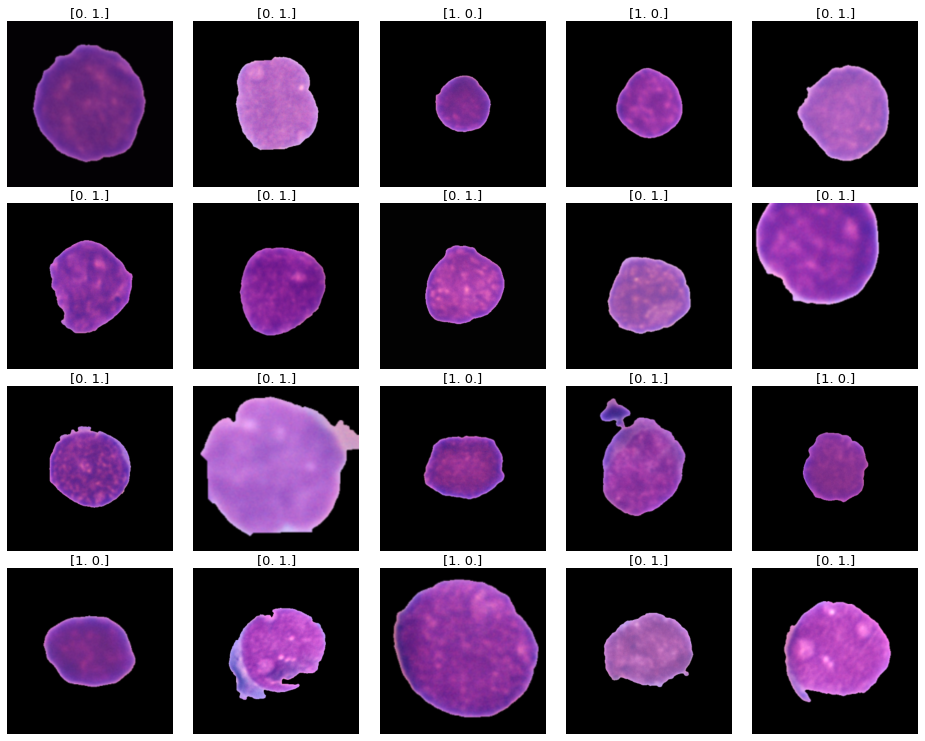

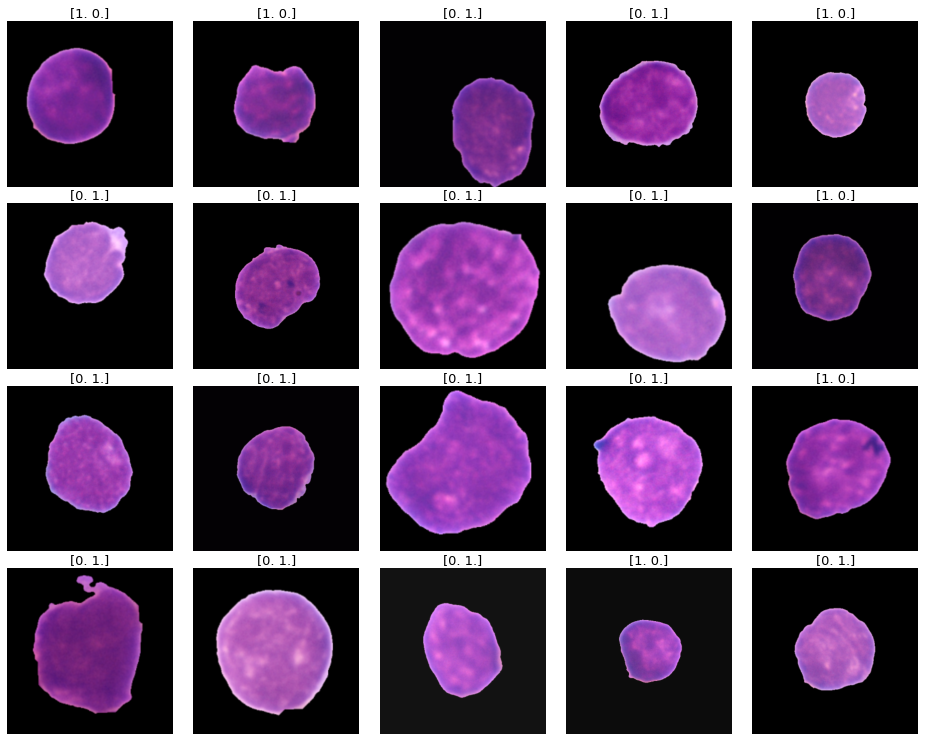

In [ ]:
train_dataset = get_dataset(FILENAMES[:60],LABELS[:60], ordered=True,augment=True)
train_iter = iter(train_dataset.unbatch().batch(20))

display_batch_of_images(next(train_iter))
display_batch_of_images(next(train_iter))

Learning rate schedule: 1e-08 to 3e-05 to 7.22e-08


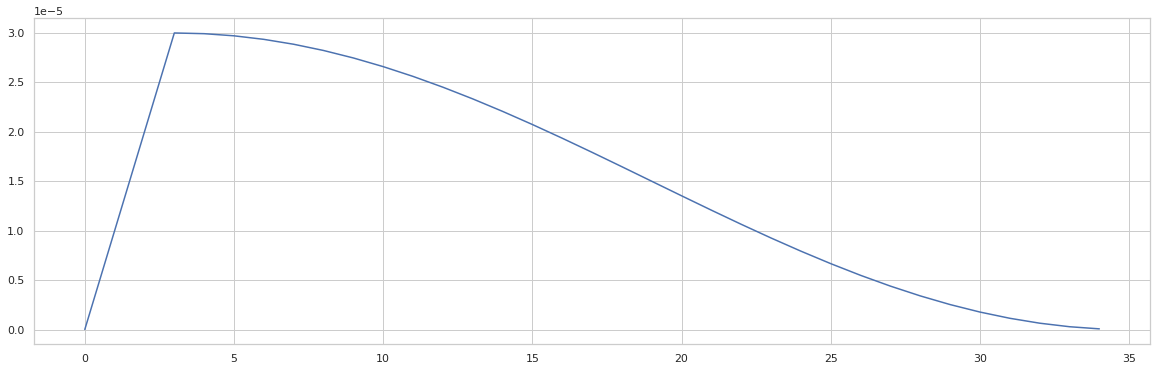

In [ ]:
# Cosine Annealing:-
LR_START = 1e-8
LR_MIN = 1e-8
LR_MAX = LEARNING_RATE
LR_RAMPUP_EPOCHS = 3
LR_SUSTAIN_EPOCHS = 0
N_CYCLES = .5


def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        progress = (epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) / (EPOCHS - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS)
        lr = LR_MAX * (0.5 * (1.0 + tf.math.cos(math.pi * N_CYCLES * 2.0 * progress)))
        if LR_MIN is not None:
            lr = tf.math.maximum(LR_MIN, lr)

    return lr

rng = [i for i in range(EPOCHS)]
y = [lrfn(x) for x in rng]

sns.set(style='whitegrid')
fig, ax = plt.subplots(figsize=(20, 6))
plt.plot(rng, y)

# print(f'{EPOCHS} total epochs and {NUM_TRAINING_IMAGES//BATCH_SIZE} steps per epoch')
print(f'Learning rate schedule: {y[0]:.3g} to {max(y):.3g} to {y[-1]:.3g}')

In [ ]:
import tensorflow_addons as tfa

In [ ]:
# Model Architecture :-
def model_fn(input_shape, N_CLASSES):
    input_image = L.Input(shape=input_shape, name='input_image')
    base_model = tf.keras.applications.VGG19(input_tensor=input_image,
                                    include_top=False,
                                    weights='imagenet',
                                    pooling='avg')

    for layer in base_model.layers:
        if 'bn' in layer.name:
            layer.trainable = False
        else:
            layer.trainable = True

    model = tf.keras.Sequential([
        base_model,
        L.Dropout(.25),
        L.Dense(N_CLASSES, activation='sigmoid', name='output')
    ])

    optimizer = optimizers.Adam(lr=LEARNING_RATE)
    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=['accuracy',tfa.metrics.F1Score(num_classes=2, average='weighted')])

    return model

In [ ]:
# Cross Validated training loop:-
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=seed)
oof_pred = []; oof_labels = []; history_list = []
cv1 = cv2 = 0


for fold,(idxT, idxV) in enumerate(skf.split(FILENAMES,LABELS)):
    print(f'\nFOLD: {fold+1}')
    print(f'TRAIN: {len(idxT)} VALID: {len(idxV)}')
    STEPS_PER_EPOCH = len(idxT) // BATCH_SIZE


    K.clear_session()
    with strategy.scope():
        model = model_fn((None, None, CHANNELS), 2)

    model_path = f'model_{fold}.h5'
    es = EarlyStopping(monitor='val_f1_score', mode='max',
                    patience=ES_PATIENCE, restore_best_weights=True, verbose=1)

    ## TRAIN
    history = model.fit(x=get_dataset(FILENAMES[idxT],LABELS[idxT], ordered=False, repeated=True, augment=True),
                        validation_data=get_dataset(FILENAMES[idxV],LABELS[idxV] , ordered=True, repeated=False, augment=False),
                        steps_per_epoch=STEPS_PER_EPOCH,
                        callbacks=[es, LearningRateScheduler(lrfn ,verbose=0)],
                        epochs=EPOCHS,
                        verbose=1,
                        class_weight = cw).history

    model.save_weights(model_path)
    history_list.append(history)
    # Save last model weights


    ## RESULTS
    print(f"#### FOLD {fold+1} Accuracy = {np.max(history['accuracy']):.3f}")
    print(f"#### FOLD {fold+1} F1_score = {np.max(history['f1_score']):.3f}")
    cv1 += np.max(history['accuracy'])
    cv2 += np.max(history['f1_score'])


print(f'### Avg. Accuracy = {cv1/3.0} \n ### Avg. Weighted F1 = {cv2/3.0}')


FOLD: 1
TRAIN: 7107 VALID: 3554
80142336/80134624 [==============================] - 3s 0us/step
Epoch 1/35
222/222 [==============================] - 304s 1s/step - loss: 0.9119 - accuracy: 0.3331 - f1_score: 0.1795 - val_loss: 1.1090 - val_accuracy: 0.3180 - val_f1_score: 0.1534
Epoch 2/35
222/222 [==============================] - 278s 1s/step - loss: 0.6848 - accuracy: 0.5638 - f1_score: 0.5685 - val_loss: 0.5186 - val_accuracy: 0.7746 - val_f1_score: 0.7788
Epoch 3/35
222/222 [==============================] - 278s 1s/step - loss: 0.5630 - accuracy: 0.7145 - f1_score: 0.7225 - val_loss: 0.4674 - val_accuracy: 0.7859 - val_f1_score: 0.7901
Epoch 4/35
222/222 [==============================] - 277s 1s/step - loss: 0.5200 - accuracy: 0.7501 - f1_score: 0.7552 - val_loss: 0.8807 - val_accuracy: 0.5321 - val_f1_score: 0.5183
Epoch 5/35
222/222 [==============================] - 278s 1s/step - loss: 0.5128 - accuracy: 0.7643 - f1_score: 0.7696 - val_loss: 0.3973 - val_accuracy: 0.8410 


FOLD: 1


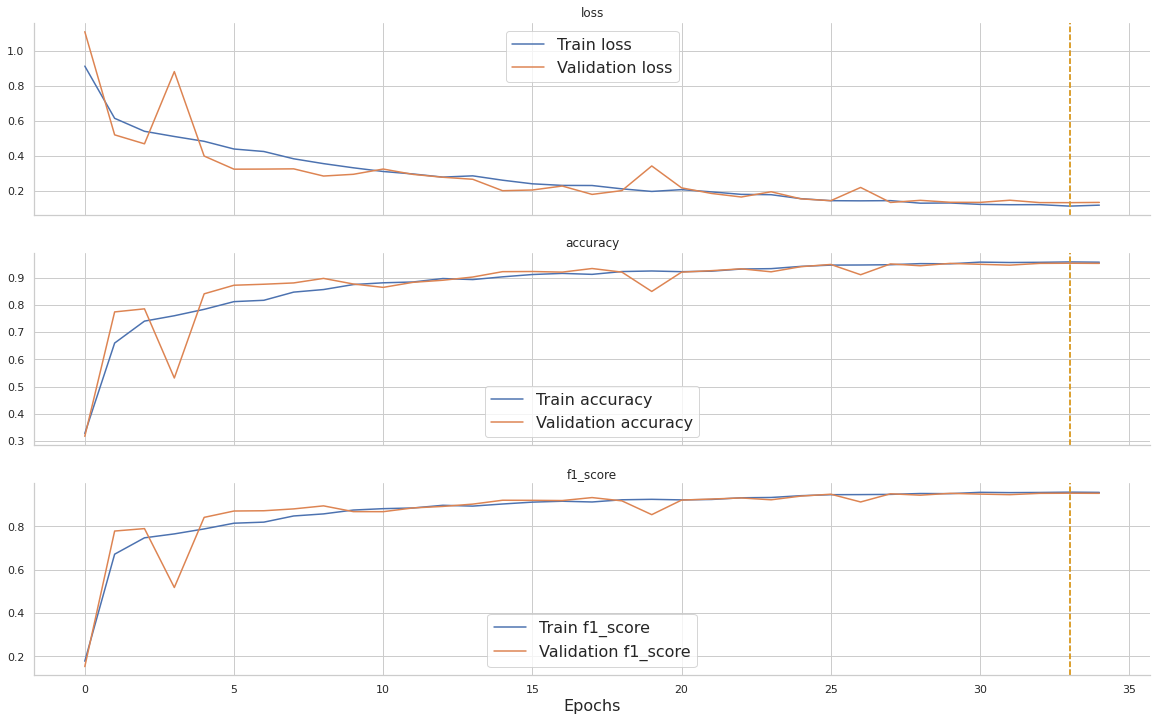


FOLD: 2


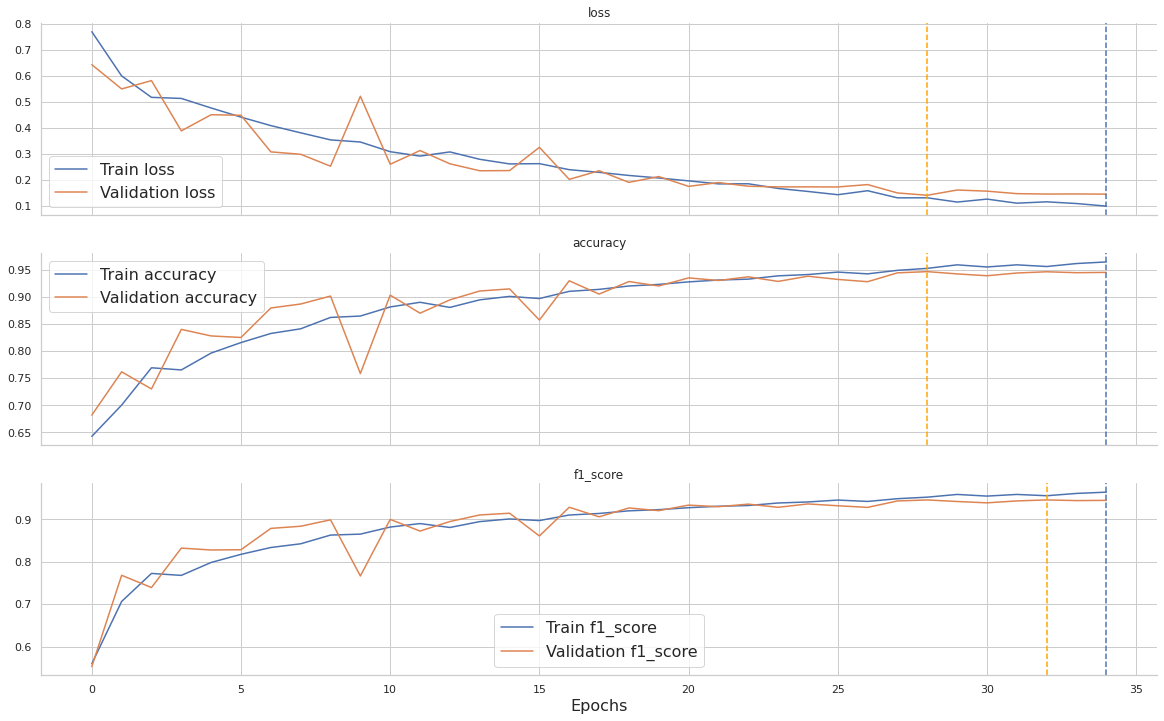


FOLD: 3


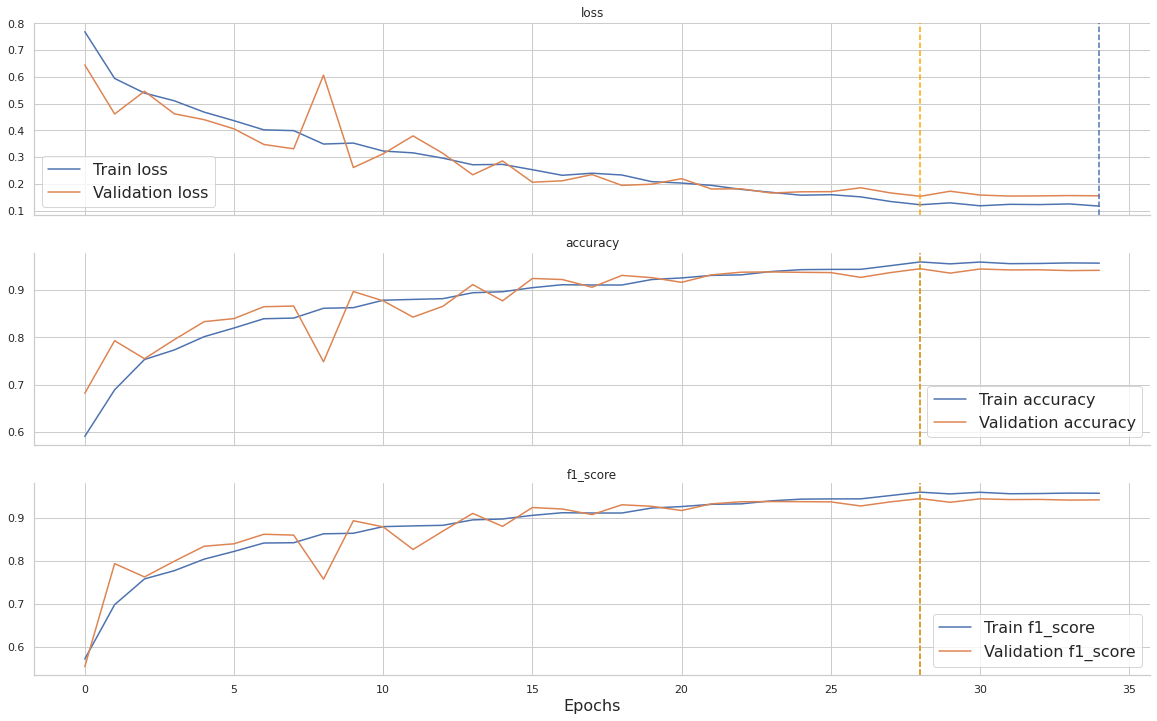

In [ ]:
# Plot metrics:-
for fold, history in enumerate(history_list):
    print(f'\nFOLD: {fold+1}')
    plot_metrics(history)

In [ ]:
TA=[]
TH=[]

TA.extend(ATL)
TH.extend(HTL)

print(len(TA))
print(len(TH))

# Create labels :-
Label_TA = [1]*len(TA)
Label_TH = [0]*len(TH)

# Converting to pandas dataframe for easier access:-
TA.extend(TH)
Label_TA.extend(Label_TH)
tdf = pd.DataFrame({'path':TA, 'label':Label_TA})
tdf = tdf.sample(frac=1).reset_index(drop=True)
TFILENAMES = tdf['path']
TLABELS = tdf['label']


print('Test Merged Data:-')
tdf

1219
648
Test Merged Data:-


,path,label
0,../input/leukemia-classification//C-NMC_Leukem...,1
1,../input/leukemia-classification//C-NMC_Leukem...,0
2,../input/leukemia-classification//C-NMC_Leukem...,1
3,../input/leukemia-classification//C-NMC_Leukem...,0
4,../input/leukemia-classification//C-NMC_Leukem...,0
...,...,...
1862,../input/leukemia-classification//C-NMC_Leukem...,1
1863,../input/leukemia-classification//C-NMC_Leukem...,1
1864,../input/leukemia-classification//C-NMC_Leukem...,1
1865,../input/leukemia-classification//C-NMC_Leukem...,1


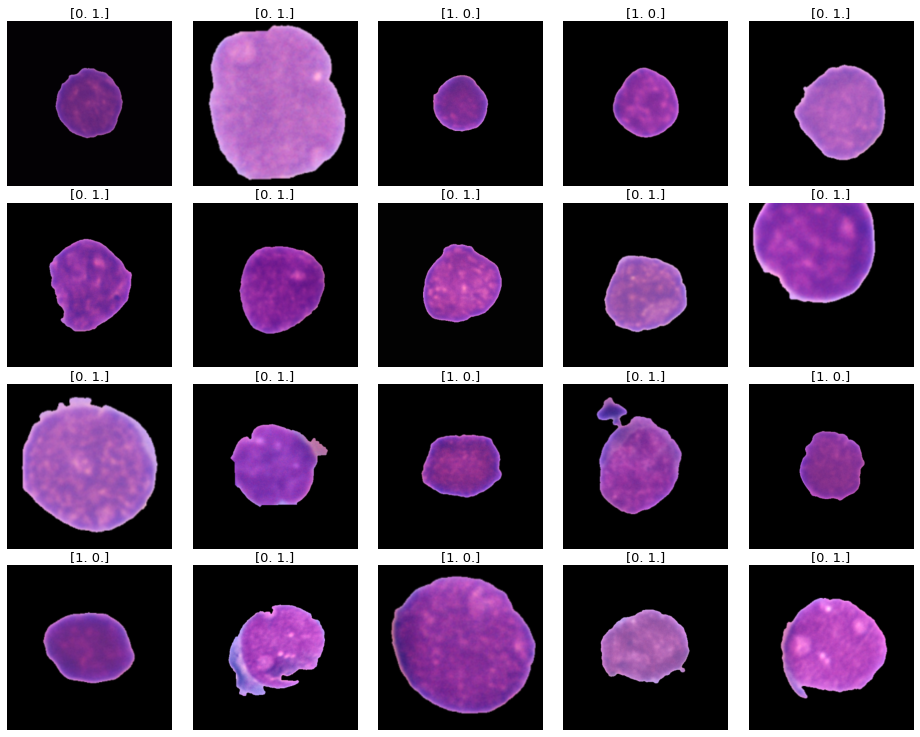

In [ ]:
test_dataset = get_dataset(TFILENAMES[:1867],TLABELS[:1867], ordered=True,augment=True)
test_iter = iter(train_dataset.unbatch().batch(20))

display_batch_of_images(next(test_iter))


In [ ]:
accu = model.evaluate(test_dataset)

59/59 [==============================] - 21s 341ms/step - loss: 0.5541 - accuracy: 0.7740 - f1_score: 0.7637


(1, 600, 600, 3)

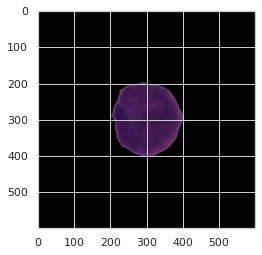

In [ ]:
import PIL
from PIL import Image
im1 = Image.open(GCS_PATH + '/C-NMC_Leukemia/testing_data/C-NMC_test_final_phase_data/1105.bmp')
p1 = np.array(im1)
plt.imshow(p1)
p1 = np.expand_dims(p1, axis=0)
p1.shape

Prediction is Hem
Prediction Confidence Percentage is:  24.607495963573456


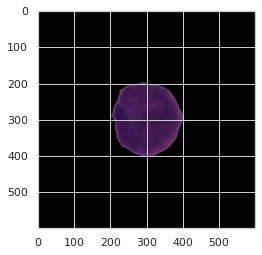

In [ ]:
preds = model.predict(p1)
prediction = np.argmax(preds)
pct = np.max(preds)
if prediction == 0:
    print('The Prediction of the sample is: It Is ALL')
else:
    print('Prediction is Hem')
print("Prediction Confidence Percentage is: ", pct*100)
plt.imshow(im1);